In [ ]:
#第一モデルで吐いたエラーを調査するためのプログラム

In [ ]:
#vh hardnessのプログラムを1stモデル用に変えたものを使ってvh hardnessを予測する

In [3]:
from os.path import join
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from crabnet.utils.data import get_data
from crabnet.crabnet_ import CrabNet
import vickers_hardness.data as vh_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
)
from vickers_hardness.utils.plotting import parity_with_err
from vickers_hardness.vickers_hardness_ import VickersHardness

In [4]:
# %% load dataset
X = get_data(vh_data, "hv_des.csv", groupby=False, split=False).rename(
    columns={"composition": "formula"}
)
prediction = get_data(vh_data, "hv_comp_load.csv", groupby=False, split=False)
y = prediction["hardness"]
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)

In [5]:
# %% K-fold cross-validation
ss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
cv = GroupKFold()
cvtype = "gcv"
groups = X["formula"]

trainval_idx, test_idx = list(ss.split(X, y, groups=groups))[0]


X_test, y_test = X.iloc[test_idx, :], y[test_idx]
X, y = X.iloc[trainval_idx, :], y.iloc[trainval_idx]

subgroups = X["formula"]

crabnet_dfs = []

In [8]:
for train_index, test_index in cv.split(X, y, subgroups):#上記のcvをしたそれぞれのデータセットのペアごとに処理を実行
    X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    train_df = pd.DataFrame(
        {"formula": X_train["formula"], "target": y_train}
    )
    val_df = pd.DataFrame(
        {"formula": X_val["formula"], "target": y_val}
    )
    
    display(train_df)
    display(val_df)
    
    cb = CrabNet(#ここでCrabNetのモデルを作成 学習時に表示されている学習曲線の表示や学習時のbatch数などについてはここで設定を行う
                 #今回のモデルだとデフォルトのbatch数は128
        verbose=True,
        learningcurve=True,
        losscurve = True,
        random_state = 42,
    )
    
    break

,formula,target
1,Ag0.05Y0.048Pd0.902,1.640
4,Al1.67B22,23.800
5,Al3BC3,20.700
6,Al3BC3,18.200
7,Al3BC3,11.100
...,...,...
1053,ZrMoAl,6.523
1055,ZrO2,13.000
1059,OsB2,34.800
1060,OsB2,27.000


,formula,target
0,Ag0.05Gd0.048Pd0.902,1.810000
3,Al1.5Si1.5N2.5O1.5,15.030000
17,AuSn,1.420000
22,B13N2,44.384000
23,B13N2,42.019435
...,...,...
1024,Zr0.8Mo2Ge0.2,8.947000
1035,Zr5Ge3,11.700000
1051,ZrMn2,7.860000
1056,ZrRh3,6.370000



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 620/620 [00:00<00:00, 148972.76formulae/s]

loading data with up to 5 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 156/156 [00:00<00:00, 203962.41formulae/s]

loading data with up to 5 elements in the formula
stepping every 50 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 11 val mae: 10.8


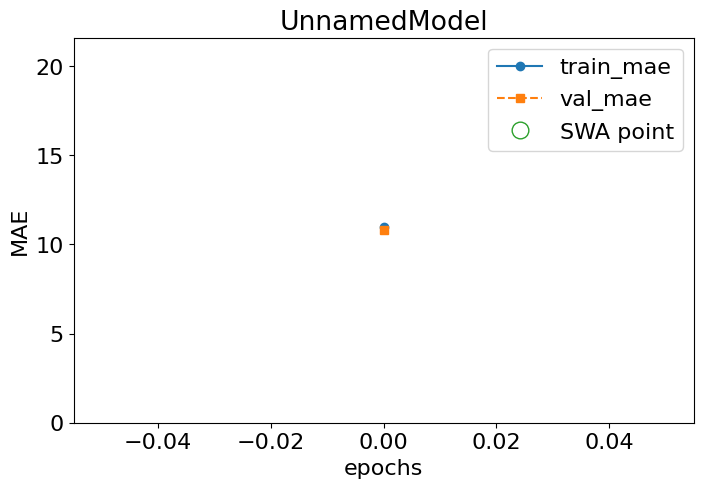

KeyboardInterrupt: 

In [9]:
cb.fit(train_df)#モデル訓練　内容は不明だがもしかして完成したモデルの出力も行われている可能性がある

y_pred, y_std, y_true,  = cb.predict(test_df = val_df, return_uncertainty = True, return_true = True)#原文ママではエラー　原因は出力が4つも出てこないということ、実際オプションでy_trueおよびy_stdを追加することは可能
#ただし、何もオプションを入れていない時点では、予測された結果値のみが出力される
#得られるstdは予測された値の標準偏差を示している
crabnet_dfs.append(#答えのファイルの作成
    pd.DataFrame(
        {
            "actual_hardness": y_true,
            "predicted_hardness": y_pred,
            "y_std": y_std,
            "load": val_df["load"],
            "formula": val_df["formula"],
        }
    )
)